In [1]:
import os
import numpy as np
import pandas as pd

tuhab_meta_csv_path = '/home/gayal/ssl-project/gpatchTST/tuhab_patient_metadata.csv'
model_path = '/home/gayal/ssl-project/gpatchTST/saved_models/pretrain/tuhab_pretrain_tuab_fixed/TUH-83/2025-04-14_16-31-47'
# get the yaml
config_dilename = [file for file in os.listdir(model_path) if file.endswith('.yaml')].pop()
checkpoint_files = [file for file in os.listdir(model_path) if file.endswith('.pth')]

config_filepath = os.path.join(model_path, config_dilename)
checkpoint_paths = [os.path.join(model_path, path) for path in checkpoint_files]

print(config_filepath)

/home/gayal/ssl-project/gpatchTST/saved_models/pretrain/tuhab_pretrain_tuab_fixed/TUH-83/2025-04-14_16-31-47/test_pretrain_repo_tuhab.yaml


In [2]:
from configs import Config

config = Config(config_file=config_filepath).get()

data_config = config['data']
model_config = config['model']



In [3]:
metadata_df = pd.read_csv(tuhab_meta_csv_path)
metadata_df.head()

,recording_name,patient_name,age,gender,split,label
0,aaaaaaaq_s004_t000,aaaaaaaq,26,F,train,abnormal
1,aaaaaaaq_s005_t001,aaaaaaaq,27,F,train,abnormal
2,aaaaaaat_s002_t001,aaaaaaat,49,M,train,abnormal
3,aaaaaaav_s004_t000,aaaaaaav,35,F,train,normal
4,aaaaaabn_s005_t000,aaaaaabn,24,F,train,normal


In [4]:
# loading data
from data import get_tuh_dataloaders

# Create data loaders
train_loader, val_loader, test_loader = get_tuh_dataloaders(
    data_config['root_path'],
    data_config['data_path'],
    data_config['csv_path'],
    batch_size=data_config['batch_size'],
    num_workers=data_config['num_workers'],
    size=[model_config['seq_len'], 
          model_config['target_dim'],
          model_config['patch_length']]
)

train_sample = next(iter(train_loader))
val_sample = next(iter(val_loader))
test_sample = next(iter(test_loader))

/home/gayal/ssl-project/PatchTST/patch_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: train, Patients: 1450, Files: 1783
Total Sequences: 126073
Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: val, Patients: 207, Files: 258
Total Sequences: 18398
Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: test, Patients: 415, Files: 528
Total Sequences: 36970


In [5]:
# loading model checkpoints
from get_models import get_patchTST_model
import torch

check_point_path = checkpoint_paths[0]

num_patches = (max(model_config['seq_len'], model_config['patch_length']) - model_config['patch_length']) // model_config['stride'] + 1
train_num_mask_patches = int(model_config['mask_ratio']* num_patches)
print(f"num_patches: {num_patches}, train_num_mask_patches: {train_num_mask_patches}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = get_patchTST_model(num_variates=data_config['n_vars'],
                            forecast_length=data_config['pred_len'],
                            patch_len=model_config['patch_length'],
                            stride=model_config['stride'],
                            num_patch=num_patches,
                            n_layers=model_config['num_layers'],
                            d_model=model_config['d_model'],
                            n_heads=model_config['num_heads'],
                            shared_embedding=model_config['shared_embedding'],
                            d_ff=model_config['d_ff'],
                            norm=model_config['norm'],
                            attn_dropout=model_config['attn_dropout'],
                            dropout=model_config['dropout'],
                            activation=model_config['activation'],
                            res_attention=model_config['res_attention'],
                            pe=model_config['pe'],
                            learn_pe=model_config['learn_pe'],
                            head_dropout=model_config['head_dropout'],
                            head_type=model_config['head_type']
                        ).to(device)

model.load_state_dict(torch.load(check_point_path)['model_state_dict'])#, weights_only=True))
model.eval()

num_patches: 10, train_num_mask_patches: 3
Using device: cuda


PatchTST(
  (backbone): PatchTSTEncoder(
    (W_P): Linear(in_features=100, out_features=128, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (encoder): TSTEncoder(
      (layers): ModuleList(
        (0): TSTEncoderLayer(
          (self_attn): MultiheadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=True)
            (W_K): Linear(in_features=128, out_features=128, bias=True)
            (W_V): Linear(in_features=128, out_features=128, bias=True)
            (sdp_attn): ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.2, inplace=False)
            )
          )
          (dropout_attn): Dropout(p=0.2, inplace=False)
          (norm_attn): Sequential(
            (0): Transpose()
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [6]:
# torch.set_grad_enabled(False)

test_sample['past_values'].shape

torch.Size([512, 1000, 19])

In [7]:
from pretrain import (create_patches, 
apply_mask, plot_sample_reconstruction, 
create_mask, apply_inv_mask)

val_mask_type = 'random'

mask_ratio = 0.3# model_config['mask_ratio']
masked_value = model_config['masked_value']
stride = model_config['stride']
independent_channel_masking = model_config['independent_channel_masking']
patch_len = model_config['patch_length']
forecasting_num_patches = model_config['forecasting_num_patches']
fixed_position = None

data = test_sample['past_values'].to(device)

input_patches, num_patches = create_patches(data, patch_len, stride)
mask = create_mask(input_patches, mask_ratio, independent_channel_masking, mask_type=val_mask_type, 
                   fixed_position=fixed_position, forecasting_num_patches=forecasting_num_patches)
masked_patches = apply_mask(input_patches, mask, masked_value)
target_patches = apply_inv_mask(input_patches, mask, masked_value)

predicted_sequence = model(masked_patches)

predicted_masked_regions = apply_inv_mask(predicted_sequence, mask, masked_value)

In [8]:
criterion = torch.nn.MSELoss(reduction='mean')

criterion(predicted_masked_regions, target_patches)

tensor(0.2079, device='cuda:0', grad_fn=<MseLossBackward0>)

In [9]:
criterion = torch.nn.MSELoss(reduction='mean')

criterion(input_patches, predicted_sequence)

tensor(0.6863, device='cuda:0', grad_fn=<MseLossBackward0>)

In [10]:
# from torchviz import make_dot
# import torch
# import torch.nn as nn

# torch.set_grad_enabled(True)

# masked_patches_viz = masked_patches.clone().detach().requires_grad_(True)

# output_viz = model(masked_patches_viz)

# graph = make_dot(output_viz, params=dict(list(model.named_parameters())))
# graph.render("model_graph", format="png")


In [10]:
# torch.onnx.export(model, masked_patches_viz, "model.onnx")

In [11]:
mask.shape

torch.Size([512, 10, 19])

In [12]:
mask[0, :, 0]

tensor([False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [13]:
# input_patches[0, :, 0]

In [16]:
# masked_patches[0, :, 0]

In [17]:
# masked_output_patches[0, :, 0]
# target_patches[0, :, 0]

In [18]:
masked_patches.shape

torch.Size([512, 10, 19, 100])

## ZSL

In [12]:
# next(iter(test_tuab_dataset))
len(test_tuab_dataset.dataset), len(test_tuab_dataset), len(test_tuab_dataset.dataset.selected_files)

(36970, 36970, 528)

In [11]:
from data import TUAB_Dataset, get_tuab_dataloaders

_, _, test_tuab_dataset = get_tuab_dataloaders(
    root_path=data_config['root_path'],
    data_path=data_config['data_path'],
    csv_path=data_config['csv_path'],
    metadata_csv_path='tuhab_patient_metadata_ds.csv',
    batch_size=1,#data_config['batch_size'],
    num_workers=data_config['num_workers'],
    drop_last=True,
    size=[model_config['seq_len'], 
          model_config['target_dim'],
          model_config['patch_length']]
)

Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: train, Patients: 1450, Files: 1783
Total Sequences: 126073
Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: val, Patients: 207, Files: 258
Total Sequences: 18398
Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: test, Patients: 415, Files: 528
Total Sequences: 36970


In [13]:
import torch
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from pretrain import (create_patches, 
apply_mask, plot_sample_reconstruction, 
create_mask, apply_inv_mask)

torch.set_grad_enabled(False)

abnormal_embeddings = []
normal_embeddings = []
all_embeddings = []
all_labels = []

print("Metadata columns:", metadata_df.columns.tolist())
print(metadata_df.head())

test_tuab_step_pbar = tqdm(test_tuab_dataset, desc="Evaluating", total=len(test_tuab_dataset), leave=False)
        
for batch in test_tuab_step_pbar:
    data = batch['past_values'].to(device)  # [batch_size, seq_len, channels]
    labels = batch['label']  # [batch_size]
    ages = batch['age']      # [batch_size]
    genders = batch['gender'] # [batch_size]
    
    input_patches, _ = create_patches(data, patch_len, stride)  # [batch_size, num_patches, patch_len, channels]
    
    with torch.no_grad():
        embeddings = model.backbone(input_patches)  # [batch_size, d_model]
    
    embeddings_cpu = embeddings.detach().cpu().numpy()  # [batch_size, d_model]
    
    # Process batch more efficiently with vectorized operations
    # Create mask for abnormal samples
    abnormal_mask = np.array([label == 'abnormal' for label in labels])
    
    # Categorize embeddings by label
    abnormal_embeddings.extend(embeddings_cpu[abnormal_mask])
    normal_embeddings.extend(embeddings_cpu[~abnormal_mask])
    
    # Add all embeddings and their corresponding labels
    all_embeddings.extend(embeddings_cpu)
    all_labels.extend([1 if mask else 0 for mask in abnormal_mask])

Metadata columns: ['recording_name', 'patient_name', 'age', 'gender', 'split', 'label']
       recording_name patient_name  age gender  split     label
0  aaaaaaaq_s004_t000     aaaaaaaq   26      F  train  abnormal
1  aaaaaaaq_s005_t001     aaaaaaaq   27      F  train  abnormal
2  aaaaaaat_s002_t001     aaaaaaat   49      M  train  abnormal
3  aaaaaaav_s004_t000     aaaaaaav   35      F  train    normal
4  aaaaaabn_s005_t000     aaaaaabn   24      F  train    normal


Collected 19261 normal embeddings and 17709 abnormal embeddings


ValueError: Found array with dim 4. TSNE expected <= 2.

In [15]:
len(abnormal_embeddings)+ len(normal_embeddings), len(all_embeddings), len(all_labels)

(36970, 36970, 36970)

In [26]:
all_embeddings.shape, all_labels.shape

((36970, 19, 128, 10), (36970,))

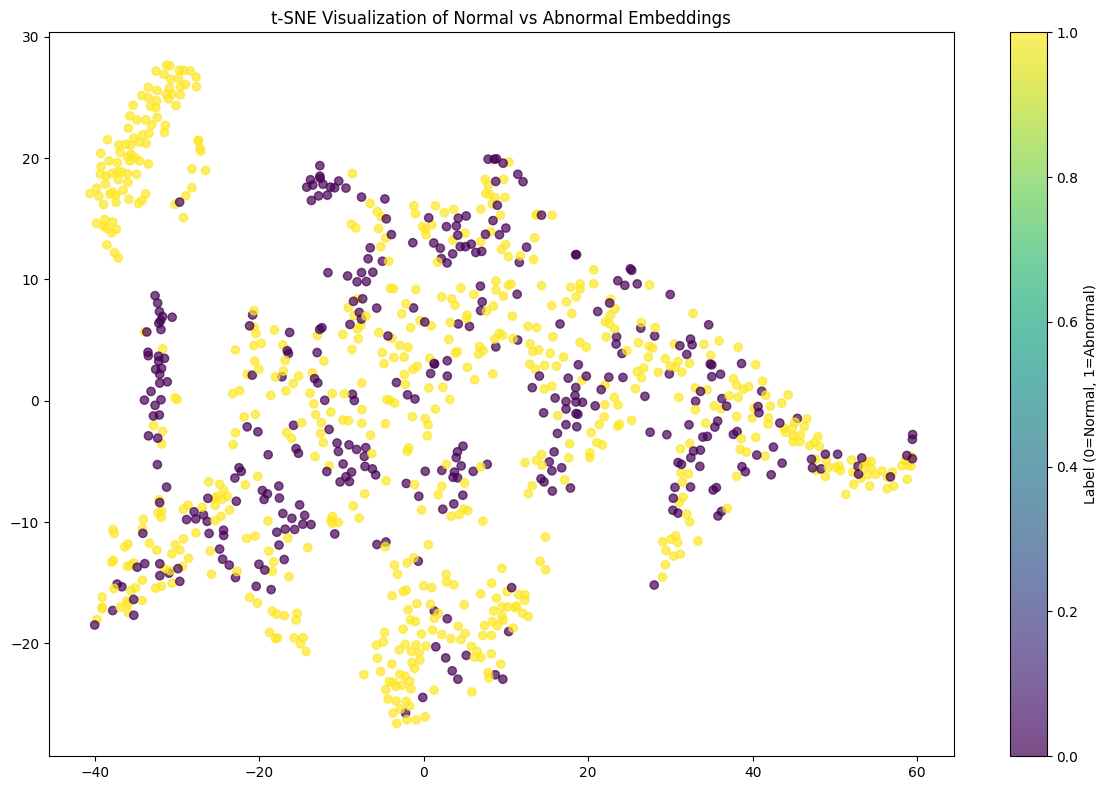

/home/gayal/ssl-project/PatchTST/patch_venv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


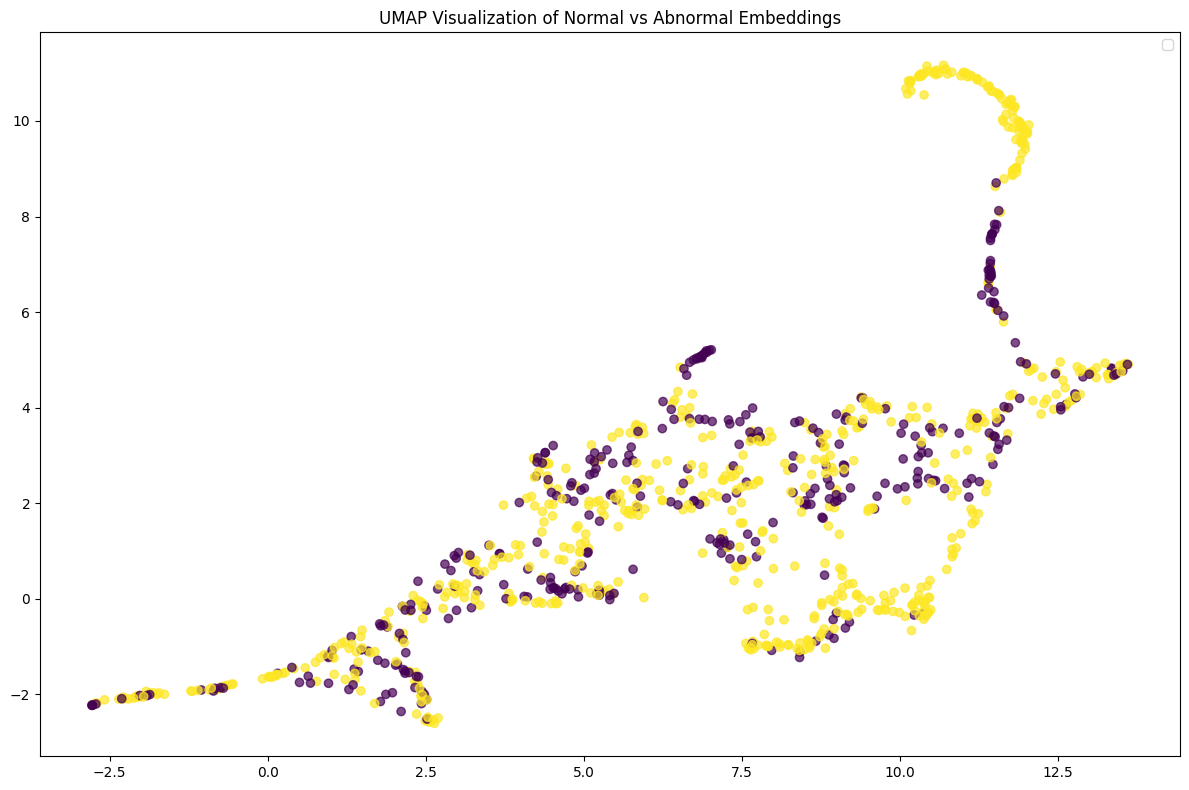

In [30]:
all_embeddings = np.array(all_embeddings)
all_embeddings_avg = all_embeddings.mean(axis=(1, 3))[:1000]
all_labels = np.array(all_labels)[:1000]

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_embeddings_avg)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
# plt.colorbar(scatter, label='Label (0=Normal, 1=Abnormal)')
plt.legend()
plt.title('t-SNE Visualization of Normal vs Abnormal Embeddings')
plt.tight_layout()
plt.savefig('tsne_visualization.png')
plt.show()

# UMAP visualization
umap_model = UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(all_embeddings_avg)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
# plt.colorbar(scatter, label='Label (0=Normal, 1=Abnormal)')
plt.legend()
plt.title('UMAP Visualization of Normal vs Abnormal Embeddings')
plt.tight_layout()
plt.savefig('umap_visualization.png')
plt.show()

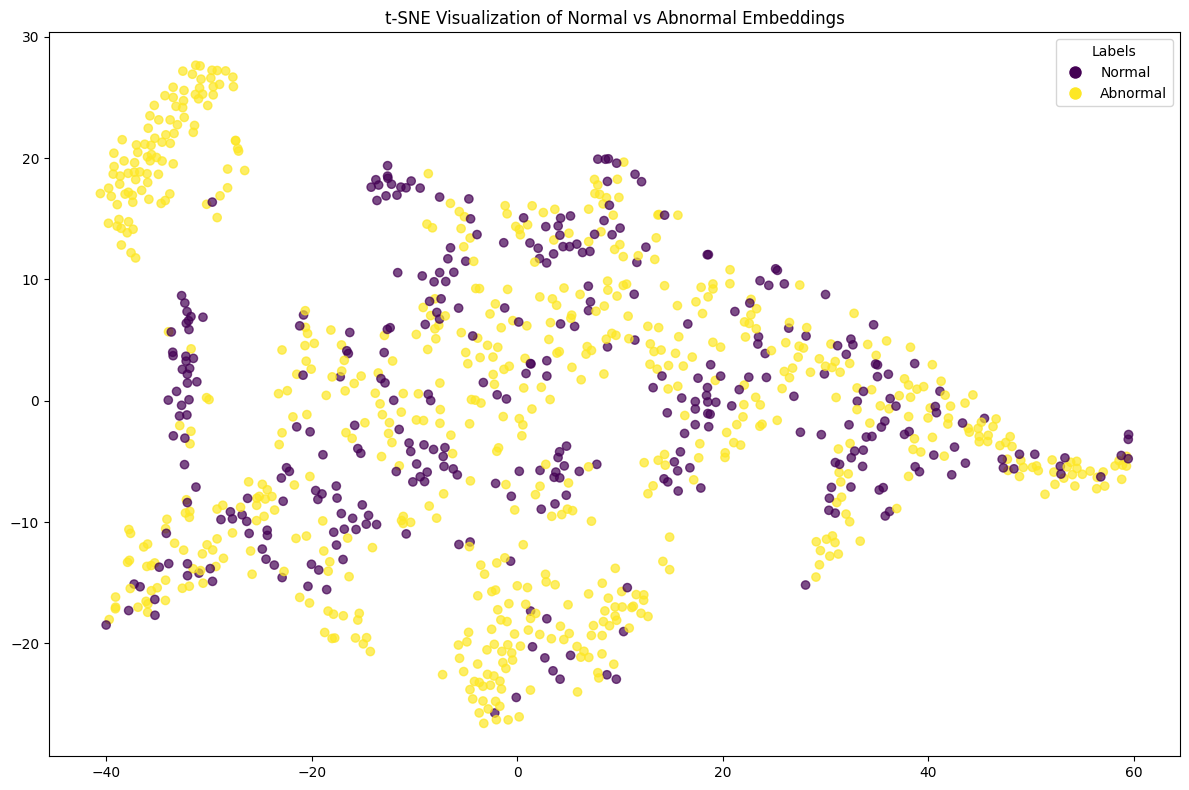

/home/gayal/ssl-project/PatchTST/patch_venv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


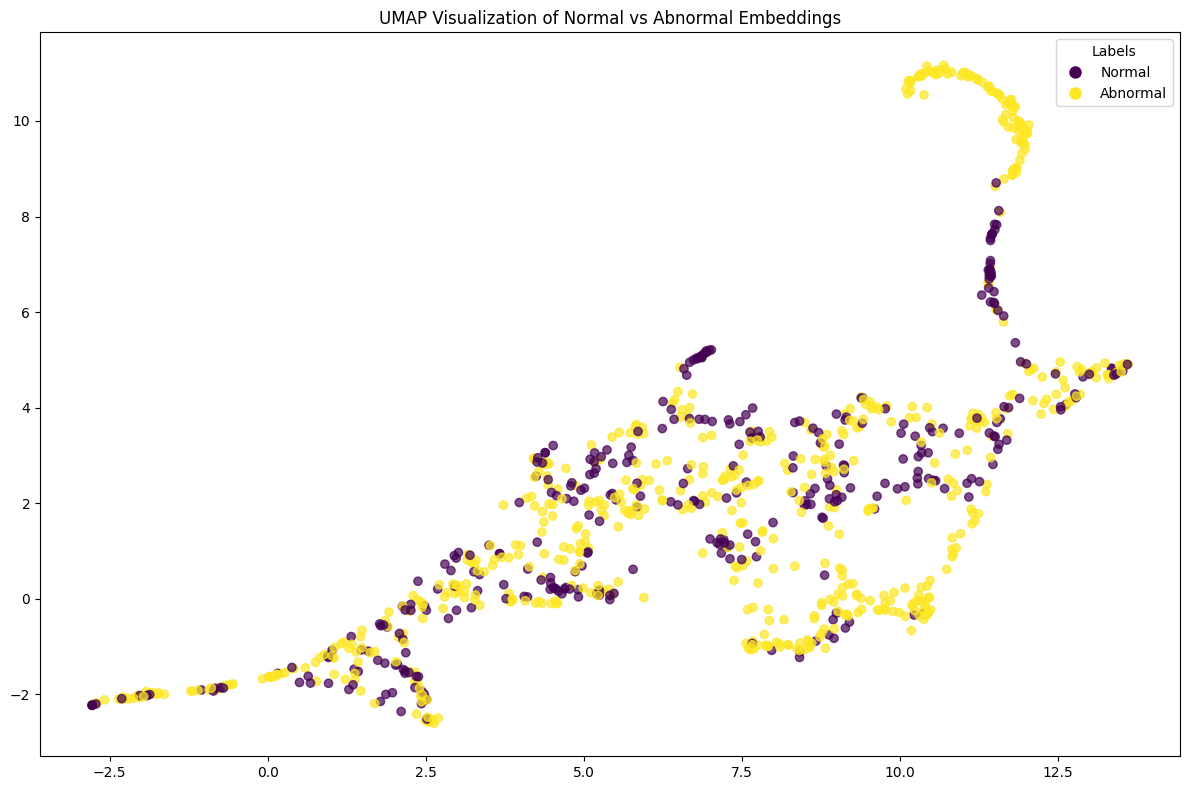

In [31]:
# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_embeddings_avg)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=all_labels, cmap='viridis', alpha=0.7)

# Add legend for labels
label_mapping = {0: "Normal", 1: "Abnormal"}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / 1), markersize=10, label=label_mapping[i]) for i in label_mapping]
plt.legend(handles=handles, title="Labels")

plt.title('t-SNE Visualization of Normal vs Abnormal Embeddings')
plt.tight_layout()
plt.savefig('tsne_visualization.png')
plt.show()

# UMAP visualization
umap_model = UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(all_embeddings_avg)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=all_labels, cmap='viridis', alpha=0.7)

# Add legend for labels
plt.legend(handles=handles, title="Labels")

plt.title('UMAP Visualization of Normal vs Abnormal Embeddings')
plt.tight_layout()
plt.savefig('umap_visualization.png')
plt.show()

In [24]:
print(data.shape, patch_len, stride)

torch.Size([1000, 19]) 100 100


In [15]:
test_file_lengths = test_loader.dataset.file_lengths
len(test_file_lengths), list(test_file_lengths.keys())[0], test_file_lengths[list(test_file_lengths.keys())[0]]

(2569, 'aaaaanad_s001_t000_preprocessed.npy', 81800)